In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, ElasticNetCV, RidgeCV, LassoCV, LassoLars
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.interpolate import make_interp_spline
import datetime

In [2]:
#use other charging csv than the ones from descriptive and clustering
charging = pd.read_csv("../charging_sessions.csv", encoding = "ISO-8859-1")
weather = pd.read_csv("../weather_burbank_airport.csv", encoding = "ISO-8859-1")

In [3]:
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])

charging['connectionTime'] = charging['connectionTime'].dt.tz_localize(None)
charging['disconnectTime'] = charging['disconnectTime'].dt.tz_localize(None)

charging = charging[~charging['id'].duplicated(keep=False)]

charging = charging.drop(columns=['Unnamed: 0', 'doneChargingTime', 'kWhDelivered', 'sessionID', 'spaceID', 'timezone', 'userID', 'userInputs'])

site_a = charging[charging["siteID"] == 1]
site_b = charging[charging["siteID"] == 2]

In [4]:
unique_spaces_a = site_a["stationID"].nunique()
unique_spaces_b = site_b["stationID"].nunique()

print(unique_spaces_a)
print(unique_spaces_b)

52
55


In [5]:
def create_utilization_demo(df) -> pd.DataFrame:
    result = []

    relevant_days = pd.date_range(
        start=df['connectionTime'].dt.date.min(), 
        end=df['disconnectTime'].dt.date.max()
    )
    relevant_days = [
        day for day in relevant_days 
        if ((df['connectionTime'].dt.date <= day.date()) & (df['disconnectTime'].dt.date >= day.date())).any()
    ]

    for day in relevant_days:
        time_slots = pd.date_range(start=day, periods=24, freq='H')
        for time in time_slots:
            utilization = np.sum((df['connectionTime'] <= time) & (df['disconnectTime'] > time))
            result.append({'time': time, 'utilization': utilization})

    return pd.DataFrame(result)

# Example usage:
utilization_demo_a = create_utilization_demo(site_a)
utilization_demo_b = create_utilization_demo(site_b)

C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\2050579353.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_slots = pd.date_range(start=day, periods=24, freq='H')


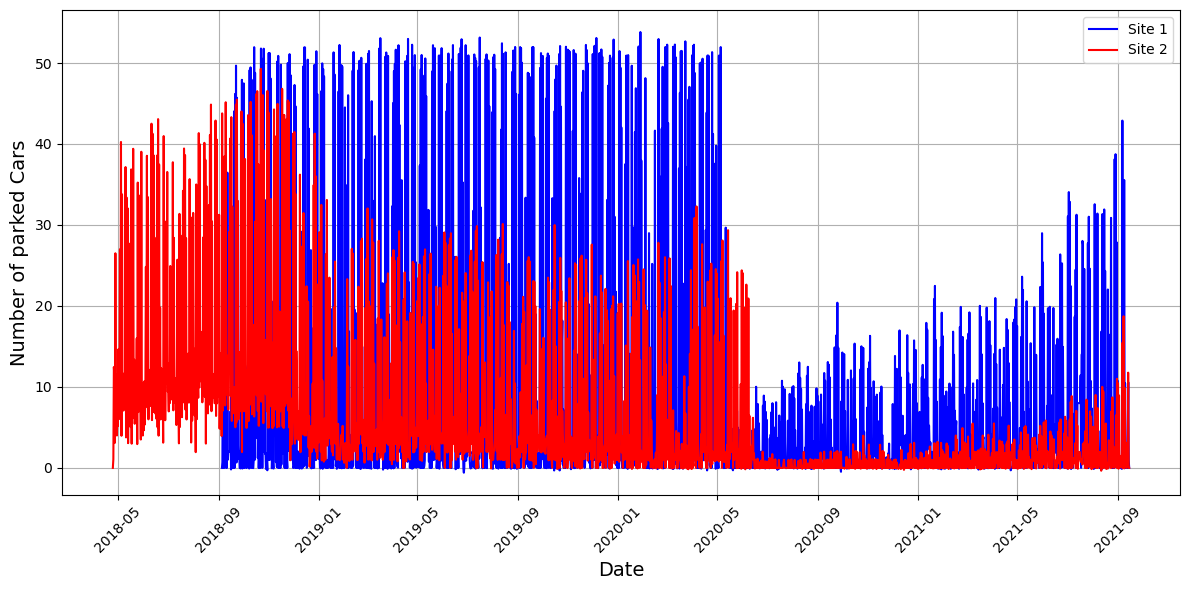

In [6]:
def smooth_curve(dataframe):

    x = np.arange(len(dataframe))  
    y = dataframe['utilization'].values

    spline = make_interp_spline(x, y, k=3)  
    x_smooth = np.linspace(x.min(), x.max(), 2000) 
    y_smooth = spline(x_smooth)

    time_smooth = np.linspace(dataframe['time'].iloc[0].timestamp(), 
                              dataframe['time'].iloc[-1].timestamp(), 
                              len(x_smooth))
    time_smooth = pd.to_datetime(time_smooth, unit='s')
    return time_smooth, y_smooth

time_smooth_a, y_smooth_a = smooth_curve(utilization_demo_a)
time_smooth_b, y_smooth_b = smooth_curve(utilization_demo_b)

plt.figure(figsize=(12, 6))
plt.plot(time_smooth_a, y_smooth_a, color='b', label='Site 1')
plt.plot(time_smooth_b, y_smooth_b, color='r', label='Site 2')


plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of parked Cars', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
def preprocess_weather_data(weather_df: pd.DataFrame) -> pd.DataFrame:

    weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])
    weather_df.set_index('timestamp', inplace=True)
    
    weather_resampled = weather_df.resample('H').interpolate(method='linear')
    
    return weather_resampled

In [8]:
def create_utilization(df, start_date, end_date, weather_resampled) -> pd.DataFrame:
    result = []
    
    # Ensure connectionTime and disconnectTime are datetime types
    if not df.empty:
        df['connectionTime'] = pd.to_datetime(df['connectionTime'])
        df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if df.empty or df['connectionTime'].max() < start_date or df['disconnectTime'].min() > end_date:
        print(f"No data available in the specified date range: {start_date} to {end_date}")
        return pd.DataFrame(result)  
    
    relevant_days = pd.date_range(
        start=max(df['connectionTime'].dt.date.min(), start_date.date()), 
        end=min(df['disconnectTime'].dt.date.max(), end_date.date())
    )
    relevant_days = [
        day for day in relevant_days 
        if ((df['connectionTime'].dt.date <= day.date()) & (df['disconnectTime'].dt.date >= day.date())).any()
    ]
    
    if not relevant_days:
        print("No relevant days found in the date range.")
        return pd.DataFrame(result)  

    for day in relevant_days:
        time_slots = pd.date_range(start=day, periods=24, freq='H')
        
        for time in time_slots:
            utilization = np.sum((df['connectionTime'] <= time) & (df['disconnectTime'] > time))
            
            temperature = np.nan  
            if time in weather_resampled.index:
                temperature = weather_resampled.loc[time, 'temperature']
            
            result.append({
                'time': time.hour,
                'utilization': utilization,
                'month': day.month,
                'isWeekday': day.weekday() < 5,
                'isMonday': day.weekday() == 0,
                'isTuesday': day.weekday() == 1,
                'isWednesday': day.weekday() == 2,
                'isThursday': day.weekday() == 3,
                'isFriday': day.weekday() == 4,
                'isSaturday': day.weekday() == 5,
                'isSunday': day.weekday() == 6,
                'temperature': temperature  
            })
    
    return pd.DataFrame(result)




In [9]:
weather_resampled = preprocess_weather_data(weather)

utilization_a = create_utilization(site_a, '2018-09-01', '2020-04-01', weather_resampled)
utilization_b = create_utilization(site_b, '2018-05-01', '2020-04-01', weather_resampled)



C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\2229645951.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_resampled = weather_df.resample('H').interpolate(method='linear')
C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\2229645951.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  weather_resampled = weather_df.resample('H').interpolate(method='linear')
C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\2435749139.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['connectionTime'] = pd.to_datetime(df['connectionTime'])
C:\Users\vigro\AppData\Local\

In [10]:
def compute_column_importance(df, target_column):
        df = df.select_dtypes(exclude=['object', 'category'])  # This excludes object-type (categorical) columns
        
        X = df.drop(columns=[target_column])
        y = df[target_column]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)
        
        feature_importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        perm_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Permutation Importance': perm_importance.importances_mean
        }).sort_values(by='Permutation Importance', ascending=False)
        
        return feature_importance_df, perm_importance_df

feature_importance_df_a, perm_importance_df_a = compute_column_importance(utilization_a, "utilization")
feature_importance_df_b, perm_importance_df_b = compute_column_importance(utilization_b, "utilization")

In [11]:
pd.set_option('display.max_rows', None)  # Show all rows    
pd.set_option('display.max_columns', None)  # Show all columns if needed
pd.set_option('display.width', None)  # Avoid line wrapping
pd.set_option('display.float_format', '{:.6f}'.format)  # Show floats in standard format
    
print(feature_importance_df_a)
print(feature_importance_df_b)

pd.reset_option('display.max_rows')

        Feature  Importance
0          time    0.472511
2     isWeekday    0.299892
10  temperature    0.129791
1         month    0.037415
7      isFriday    0.024727
3      isMonday    0.016573
9      isSunday    0.005757
5   isWednesday    0.004364
4     isTuesday    0.004289
6    isThursday    0.003602
8    isSaturday    0.001078
        Feature  Importance
0          time    0.452281
10  temperature    0.213676
2     isWeekday    0.191338
1         month    0.075809
3      isMonday    0.022319
9      isSunday    0.015035
4     isTuesday    0.007997
5   isWednesday    0.007061
7      isFriday    0.006569
6    isThursday    0.006063
8    isSaturday    0.001853


C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\3664217712.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\3664217712.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])


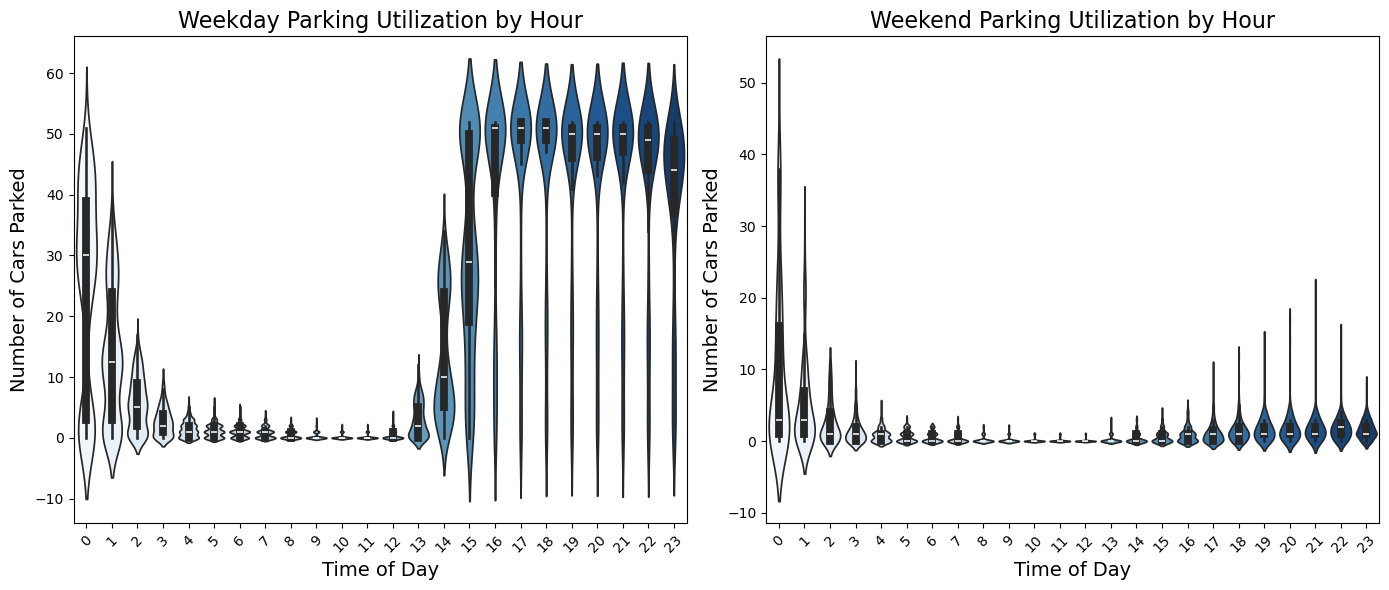

In [12]:
weekday_data = utilization_a[utilization_a['isWeekday'] == 1]
weekend_data = utilization_a[utilization_a['isWeekday'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
axes[0].set_title('Weekday Parking Utilization by Hour', fontsize=16)
axes[0].set_xlabel('Time of Day', fontsize=14)
axes[0].set_ylabel('Number of Cars Parked', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])
axes[1].set_title('Weekend Parking Utilization by Hour', fontsize=16)
axes[1].set_xlabel('Time of Day', fontsize=14)
axes[1].set_ylabel('Number of Cars Parked', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

polynomial regression

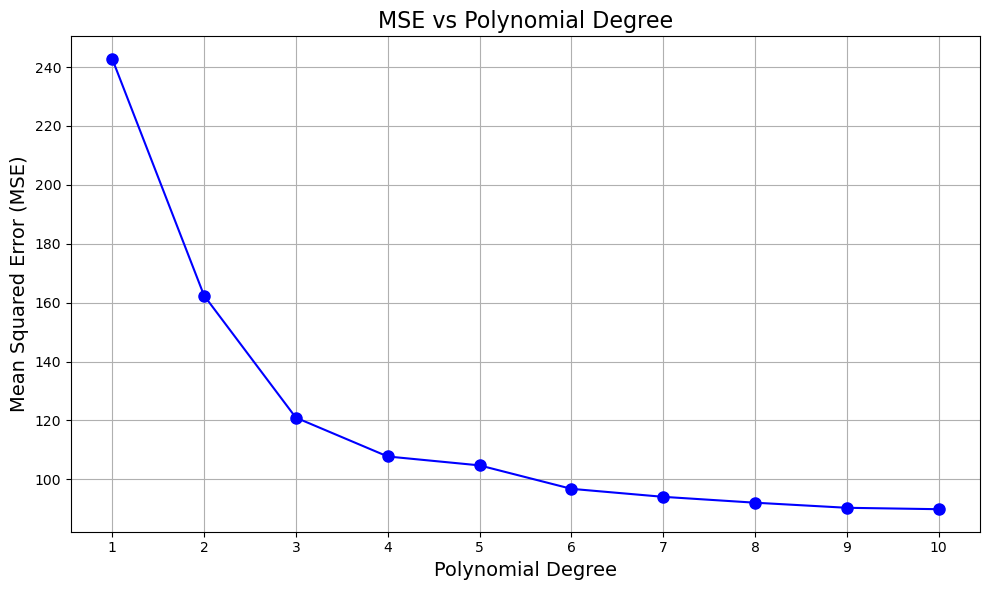

In [13]:
x_a_time = utilization_a["time"].values.reshape(-1, 1)
x_a_isWeekday = utilization_a["isWeekday"].astype(int).values.reshape(-1, 1)  # Convert boolean to int (0 or 1)

x_a = np.hstack([x_a_time, x_a_isWeekday])
y_a = utilization_a["utilization"]

mse_values = []

for poly_degree in range(1, 11):
    poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
    x_a_poly = poly.fit_transform(x_a) 

    x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a_poly, y_a, test_size=0.5, random_state=42)

    model = LinearRegression()
    model.fit(x_a_train, y_a_train)

    y_a_pred = model.predict(x_a_test)

    mse = mean_squared_error(y_a_test, y_a_pred)
    mse_values.append(mse)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mse_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('MSE vs Polynomial Degree', fontsize=16)
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))  
plt.tight_layout()
plt.show()



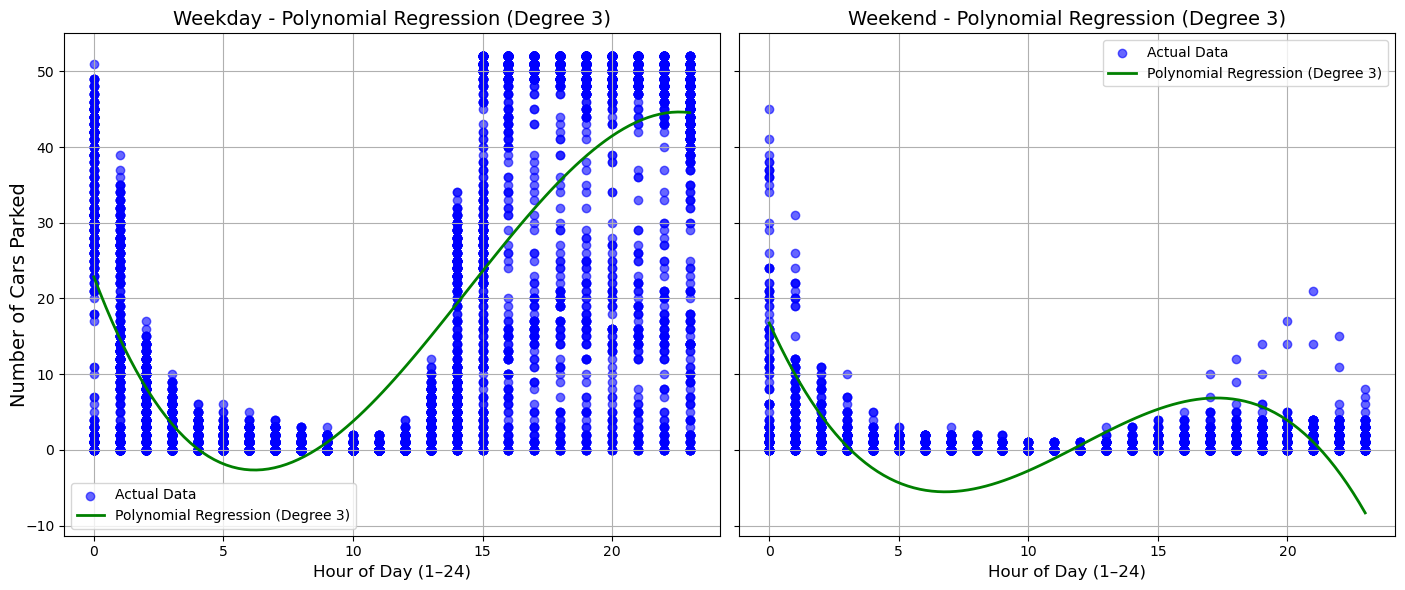

In [28]:
x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a, y_a, test_size=0.5, random_state=42)

poly = PolynomialFeatures(degree=3)

x_train_poly = poly.fit_transform(x_a_train)  
x_test_poly = poly.transform(x_a_test)  

model_a_poly = LinearRegression()
model_a_poly.fit(x_train_poly, y_a_train)

X_grid = np.linspace(min(x_a[:, 0]), max(x_a[:, 0]), 100).reshape(-1, 1)

X_grid_weekday = np.hstack([X_grid, np.ones_like(X_grid)])  
X_grid_weekend = np.hstack([X_grid, np.zeros_like(X_grid)])  

X_grid_poly_weekday = poly.transform(X_grid_weekday)  
X_grid_poly_weekend = poly.transform(X_grid_weekend)

y_grid_weekday = model_a_poly.predict(X_grid_poly_weekday)  
y_grid_weekend = model_a_poly.predict(X_grid_poly_weekend)  

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday, y_grid in zip(axes,
    ["Weekday", "Weekend"],
    [1, 0],
    [y_grid_weekday, y_grid_weekend]):
    
    x_data = x_a[x_a[:, 1] == is_weekday]
    y_data = y_a[x_a[:, 1] == is_weekday]

    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    ax.plot(X_grid, y_grid, color='green', label='Polynomial Regression (Degree 3)', linewidth=2)

    ax.set_title(f'{title} - Polynomial Regression (Degree 3)', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

fig.text(0, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()



RandomForestRegressor

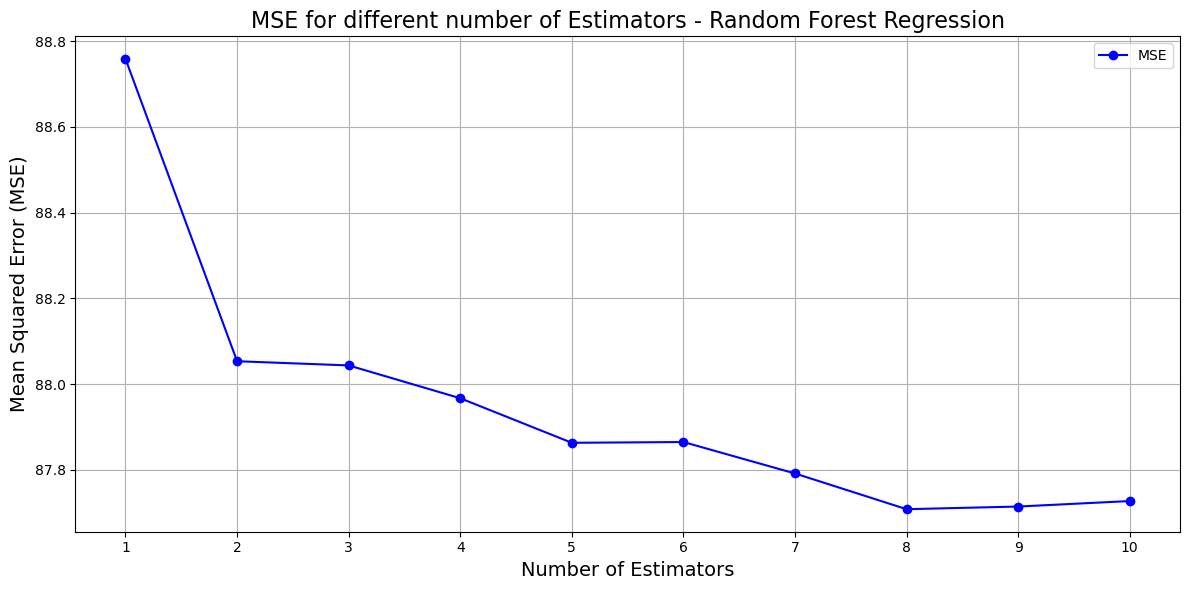

In [29]:
x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a, y_a, test_size=0.5, random_state=42)

n_estimators_range = range(1, 11, 1)
mse_values = []

for n_estimators in n_estimators_range:
    model_a_rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model_a_rf.fit(x_a_train, y_a_train)
    
    y_a_pred = model_a_rf.predict(x_a_test)
    
    mse = mean_squared_error(y_a_test, y_a_pred)
    mse_values.append(mse)

plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, mse_values, marker='o', linestyle='-', color='blue', label='MSE')
plt.title('MSE for different number of Estimators - Random Forest Regression', fontsize=16)
plt.xlabel('Number of Estimators', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.xticks(n_estimators_range)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

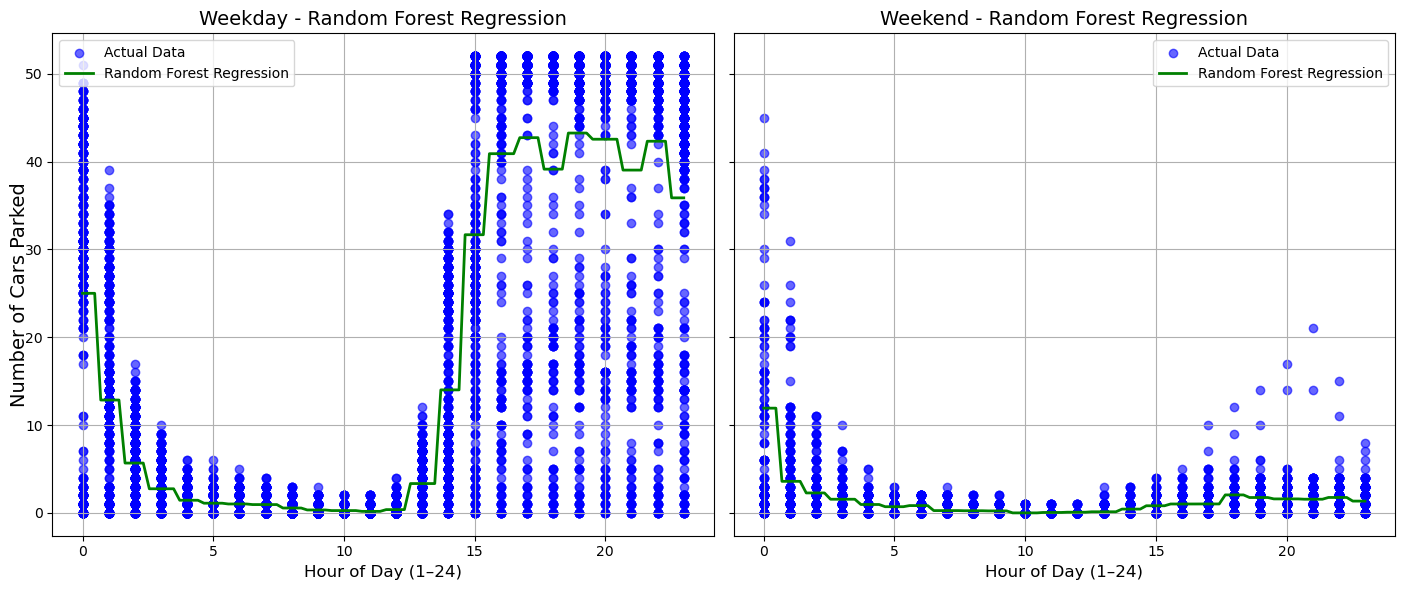

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x_a, y_a, test_size=0.5, random_state=42)

# Train a single Random Forest model with both features (Hour and isWeekday)
model_a_rf = RandomForestRegressor(n_estimators=1, random_state=42)  # You can adjust n_estimators as needed
model_a_rf.fit(x_train, y_train)

X_grid = np.linspace(min(x_a[:, 0]), max(x_a[:, 0]), 100).reshape(-1, 1)
X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_a[0, 1]])  # Add the isWeekday feature
y_grid = model_a_rf.predict(X_grid_combined)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday in zip(axes, ["Weekday", "Weekend"], [1, 0]):
    # Filter data for weekday or weekend
    x_data = x_a[x_a[:, 1] == is_weekday]
    y_data = y_a[x_a[:, 1] == is_weekday]

    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * is_weekday])  # Update for weekday/weekend
    y_grid = model_a_rf.predict(X_grid_combined)
    ax.plot(X_grid, y_grid, color='green', label='Random Forest Regression', linewidth=2)

    ax.set_title(f'{title} - Random Forest Regression', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

fig.text(0, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

neural network

4/4 [==============================] - 0s 0s/step


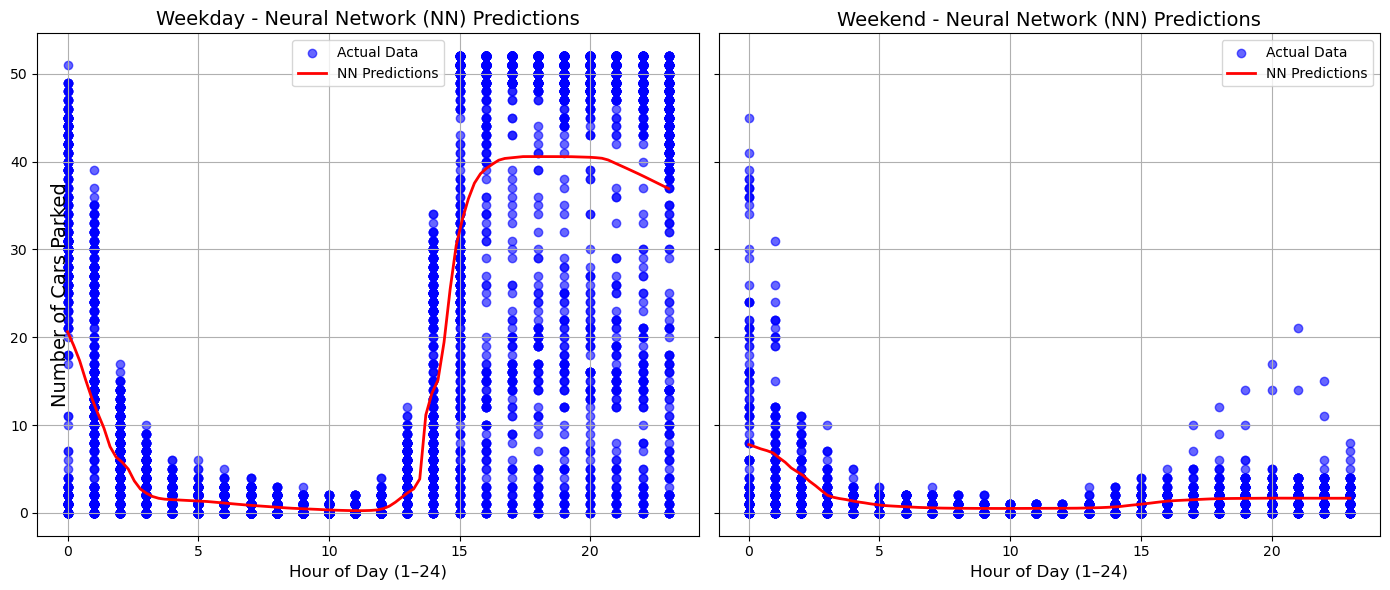

In [31]:
def build_and_train_nn(x_data, y_data):
    # Standardize the features: scale both 'time' and 'isWeekday'
    scaler = StandardScaler()
    x_data_scaled = scaler.fit_transform(x_data)  

    x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data, test_size=0.5, random_state=42)

    # Build the neural network model
    model = Sequential()
    model.add(Dense(512, input_dim=2, activation='relu'))  
    model.add(Dropout(0.3))  
    model.add(Dense(256, activation='relu'))  
    model.add(Dropout(0.3))  
    model.add(Dense(128, activation='relu'))  
    model.add(Dropout(0.3))  
    model.add(Dense(64, activation='relu'))  
    model.add(Dense(1, activation='linear'))  

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), verbose=0)

    test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)

    X_grid = np.linspace(min(x_data[:, 0]), max(x_data[:, 0]), 100).reshape(-1, 1)
    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_data[0, 1]])  
    X_grid_scaled = scaler.transform(X_grid_combined)  
    y_grid = model.predict(X_grid_scaled)

    return X_grid, y_grid, test_loss, test_mae, model, scaler

X_grid, y_grid, test_loss, test_mae, model_a_neuro, scaler = build_and_train_nn(x_a, y_a)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday in zip(
    axes, 
    ["Weekday", "Weekend"],
    [1, 0]
):
    x_data = x_a[x_a[:, 1] == is_weekday]
    y_data = y_a[x_a[:, 1] == is_weekday]
    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_data[0, 1]])  
    X_grid_scaled = scaler.transform(X_grid_combined)  
    y_grid = model_a_neuro.predict(X_grid_scaled)
    
    ax.plot(X_grid[:, 0], y_grid, color='red', label='NN Predictions', linewidth=2)

    ax.set_title(f'{title} - Neural Network (NN) Predictions', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

fig.text(0.04, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

4/4 [==============================] - 0s 0s/step


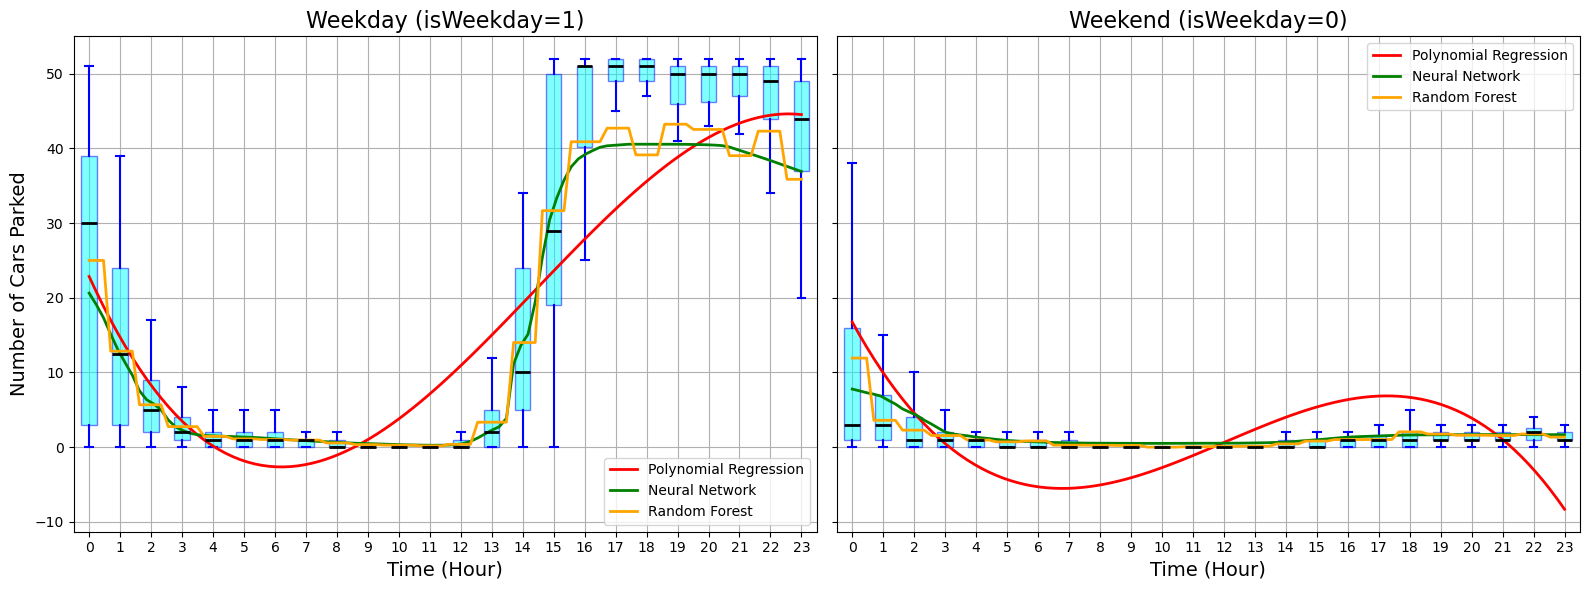

In [32]:
x_weekday = x_a[x_a[:, 1] == 1]
y_weekday = y_a[x_a[:, 1] == 1]
x_weekend = x_a[x_a[:, 1] == 0]
y_weekend = y_a[x_a[:, 1] == 0]

time_grid_weekday = np.linspace(min(x_weekday[:, 0]), max(x_weekday[:, 0]), 100).reshape(-1, 1)
X_grid_weekday = np.hstack([time_grid_weekday, np.ones_like(time_grid_weekday)])  

time_grid_weekend = np.linspace(min(x_weekend[:, 0]), max(x_weekend[:, 0]), 100).reshape(-1, 1)
X_grid_weekend = np.hstack([time_grid_weekend, np.zeros_like(time_grid_weekend)])  

X_grid_weekday_neuro = np.hstack([time_grid_weekday, np.ones_like(time_grid_weekday)])  
X_grid_weekend_neuro = np.hstack([time_grid_weekend, np.zeros_like(time_grid_weekend)]) 

X_grid_weekday_scaled_neuro = scaler.transform(X_grid_weekday)  
X_grid_weekend_scaled_neuro = scaler.transform(X_grid_weekend)

y_grid_neuro_weekday = model_a_neuro.predict(X_grid_weekday_scaled_neuro)
y_grid_neuro_weekend = model_a_neuro.predict(X_grid_weekend_scaled_neuro)


y_grid_poly_weekday = model_a_poly.predict(poly.transform(X_grid_weekday))
y_grid_rf_weekday = model_a_rf.predict(X_grid_weekday)

y_grid_poly_weekend = model_a_poly.predict(poly.transform(X_grid_weekend))
y_grid_rf_weekend = model_a_rf.predict(X_grid_weekend)

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

unique_hours_weekday = np.unique(x_weekday[:, 0])
data_for_boxplot_weekday = [y_weekday[x_weekday[:, 0] == hour] for hour in unique_hours_weekday]

axs[0].boxplot(
    data_for_boxplot_weekday,
    positions=unique_hours_weekday,
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='cyan', color='blue', alpha=0.5),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='blue', linewidth=1.5),
    capprops=dict(color='blue', linewidth=1.5),
    showfliers=False,
)
axs[0].plot(X_grid_weekday[:, 0], y_grid_poly_weekday, color='red', label='Polynomial Regression', linewidth=2)
axs[0].plot(X_grid_weekday[:, 0], y_grid_neuro_weekday, color='green', label='Neural Network', linewidth=2)
axs[0].plot(X_grid_weekday[:, 0], y_grid_rf_weekday, color='orange', label='Random Forest', linewidth=2)
axs[0].set_title('Weekday (isWeekday=1)', fontsize=16)
axs[0].set_xlabel('Time (Hour)', fontsize=14)
axs[0].set_ylabel('Number of Cars Parked', fontsize=14)
axs[0].grid(True)
axs[0].legend()

unique_hours_weekend = np.unique(x_weekend[:, 0])
data_for_boxplot_weekend = [y_weekend[x_weekend[:, 0] == hour] for hour in unique_hours_weekend]

axs[1].boxplot(
    data_for_boxplot_weekend,
    positions=unique_hours_weekend,
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='cyan', color='blue', alpha=0.5),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='blue', linewidth=1.5),
    capprops=dict(color='blue', linewidth=1.5),
    showfliers=False,
)
axs[1].plot(X_grid_weekend[:, 0], y_grid_poly_weekend, color='red', label='Polynomial Regression', linewidth=2)
axs[1].plot(X_grid_weekend[:, 0], y_grid_neuro_weekend, color='green', label='Neural Network', linewidth=2)
axs[1].plot(X_grid_weekend[:, 0], y_grid_rf_weekend, color='orange', label='Random Forest', linewidth=2)
axs[1].set_title('Weekend (isWeekday=0)', fontsize=16)
axs[1].set_xlabel('Time (Hour)', fontsize=14)
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\4071994228.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\4071994228.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])


4/4 [==============================] - 0s 0s/step


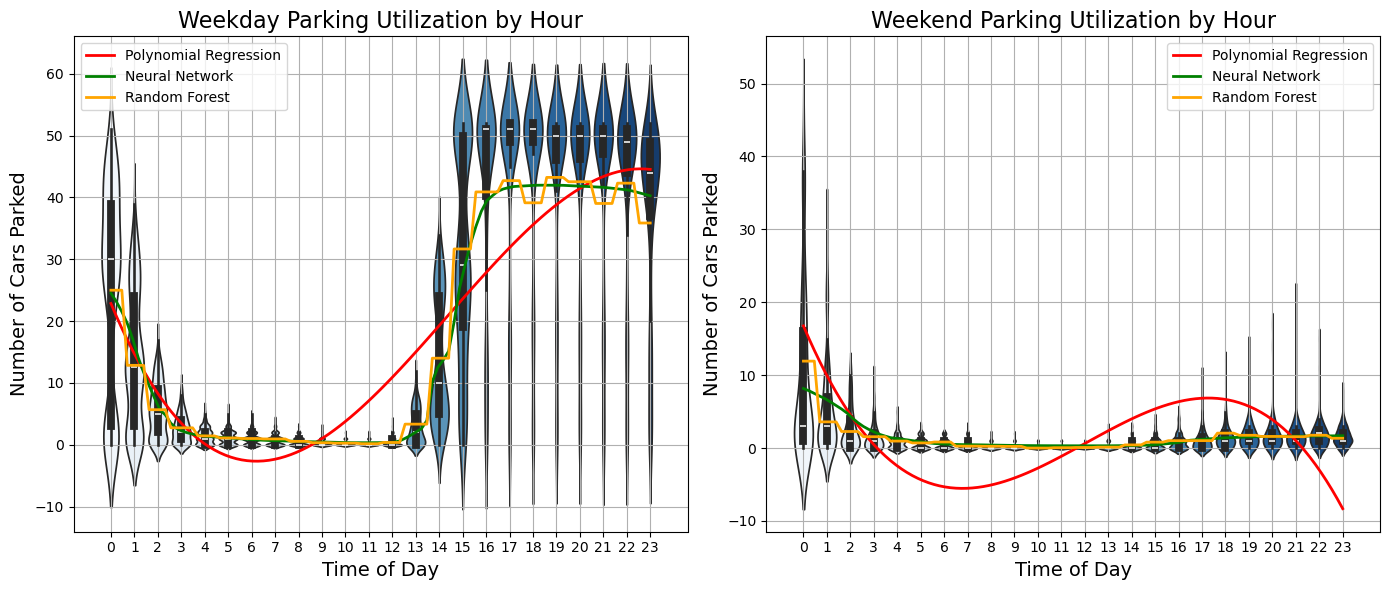

In [19]:
weekday_data = utilization_a[utilization_a['isWeekday'] == 1]
weekend_data = utilization_a[utilization_a['isWeekday'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])

time_range = np.linspace(0, 23, 100).reshape(-1, 1)  

X_grid_weekday = np.hstack([time_range, np.ones_like(time_range)])  
X_grid_weekend = np.hstack([time_range, np.zeros_like(time_range)])  

X_grid_weekday_poly = poly.transform(X_grid_weekday)  
X_grid_weekend_poly = poly.transform(X_grid_weekend)

y_grid_poly_weekday = model_a_poly.predict(X_grid_weekday_poly)
y_grid_poly_weekend = model_a_poly.predict(X_grid_weekend_poly)

y_grid_neuro_weekday = model_a_neuro.predict(scaler.transform(X_grid_weekday))
y_grid_neuro_weekend = model_a_neuro.predict(scaler.transform(X_grid_weekend))

y_grid_rf_weekday = model_a_rf.predict(X_grid_weekday)
y_grid_rf_weekend = model_a_rf.predict(X_grid_weekend)

axes[0].plot(time_range, y_grid_poly_weekday, color='red', label='Polynomial Regression', linewidth=2)
axes[0].plot(time_range, y_grid_neuro_weekday, color='green', label='Neural Network', linewidth=2)
axes[0].plot(time_range, y_grid_rf_weekday, color='orange', label='Random Forest', linewidth=2)

axes[1].plot(time_range, y_grid_poly_weekend, color='red', label='Polynomial Regression', linewidth=2)
axes[1].plot(time_range, y_grid_neuro_weekend, color='green', label='Neural Network', linewidth=2)
axes[1].plot(time_range, y_grid_rf_weekend, color='orange', label='Random Forest', linewidth=2)

axes[0].set_title('Weekday Parking Utilization by Hour', fontsize=16)
axes[1].set_title('Weekend Parking Utilization by Hour', fontsize=16)
for ax in axes:
    ax.set_xlabel('Time of Day', fontsize=14)
    ax.set_ylabel('Number of Cars Parked', fontsize=14)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


Site B

C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\458861197.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\458861197.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])


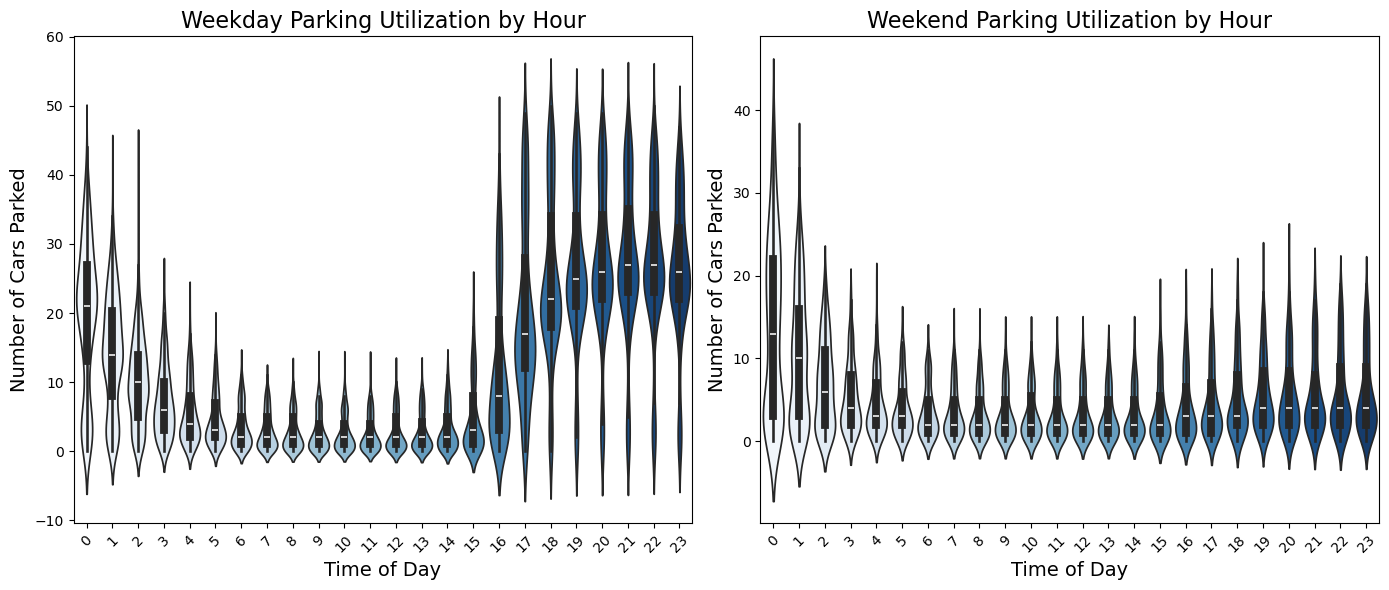

In [20]:
weekday_data = utilization_b[utilization_b['isWeekday'] == 1]
weekend_data = utilization_b[utilization_b['isWeekday'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
axes[0].set_title('Weekday Parking Utilization by Hour', fontsize=16)
axes[0].set_xlabel('Time of Day', fontsize=14)
axes[0].set_ylabel('Number of Cars Parked', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])
axes[1].set_title('Weekend Parking Utilization by Hour', fontsize=16)
axes[1].set_xlabel('Time of Day', fontsize=14)
axes[1].set_ylabel('Number of Cars Parked', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

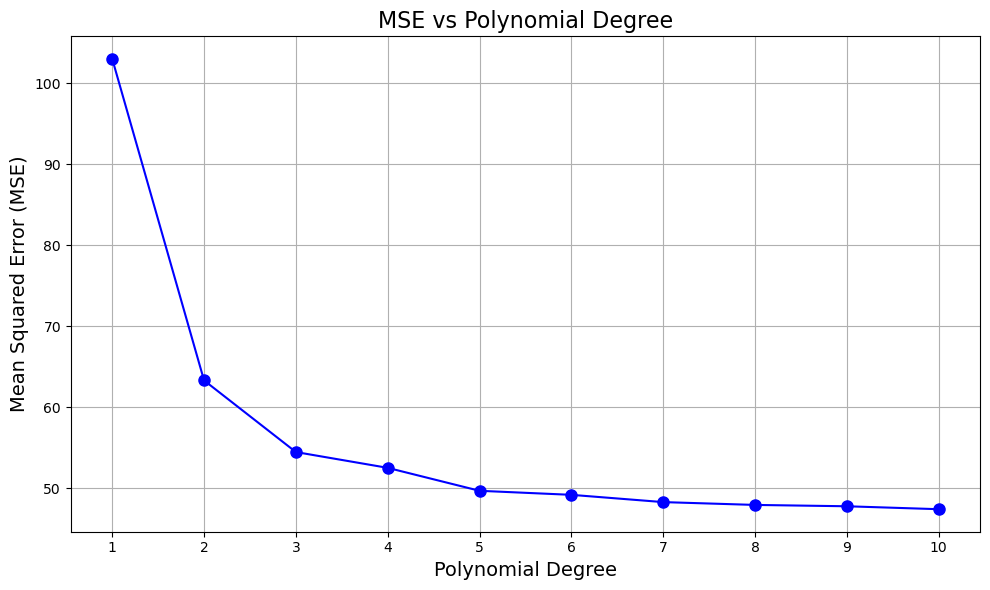

In [21]:
x_b_time = utilization_b["time"].values.reshape(-1, 1)
x_b_isWeekday = utilization_b["isWeekday"].astype(int).values.reshape(-1, 1) 

x_b = np.hstack([x_b_time, x_b_isWeekday])
y_b = utilization_b["utilization"]
mse_values = []

for poly_degree in range(1, 11):
    poly = PolynomialFeatures(degree=poly_degree)
    x_b_poly = poly.fit_transform(x_b) 

    x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(x_b_poly, y_b, test_size=0.5, random_state=42)

    model = LinearRegression()
    model.fit(x_b_train, y_b_train)

    y_b_pred = model.predict(x_b_test)

    mse = mean_squared_error(y_b_test, y_b_pred)
    mse_values.append(mse)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mse_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('MSE vs Polynomial Degree', fontsize=16)
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))  
plt.tight_layout()
plt.show()

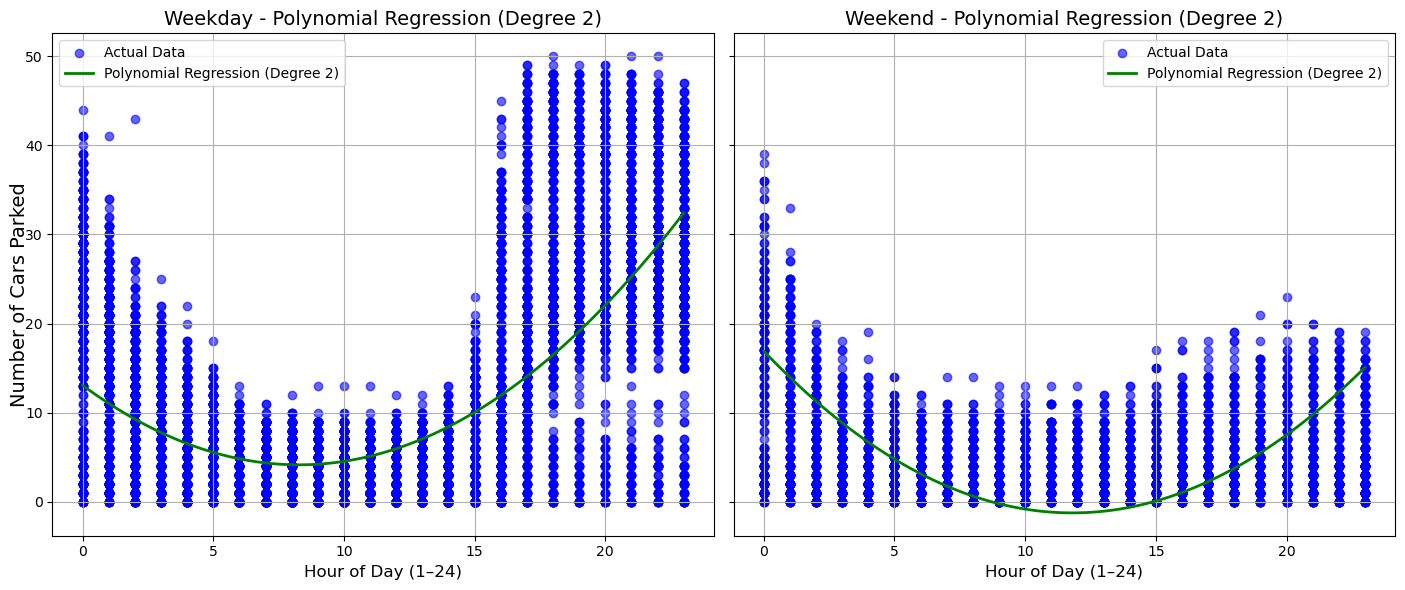

In [33]:
x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(x_b, y_b, test_size=0.5, random_state=42)

poly = PolynomialFeatures(degree=2)

x_train_poly = poly.fit_transform(x_b_train)  
x_test_poly = poly.transform(x_b_test)  

model_b_poly = LinearRegression()
model_b_poly.fit(x_train_poly, y_b_train)

X_grid = np.linspace(min(x_b[:, 0]), max(x_b[:, 0]), 100).reshape(-1, 1)

X_grid_weekday = np.hstack([X_grid, np.ones_like(X_grid)])  
X_grid_weekend = np.hstack([X_grid, np.zeros_like(X_grid)])  

X_grid_poly_weekday = poly.transform(X_grid_weekday)  
X_grid_poly_weekend = poly.transform(X_grid_weekend)

y_grid_weekday = model_b_poly.predict(X_grid_poly_weekday)  
y_grid_weekend = model_b_poly.predict(X_grid_poly_weekend)  

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday, y_grid in zip(axes,
    ["Weekday", "Weekend"],
    [1, 0],
    [y_grid_weekday, y_grid_weekend]):
    
    x_data = x_b[x_b[:, 1] == is_weekday]
    y_data = y_b[x_b[:, 1] == is_weekday]

    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    ax.plot(X_grid, y_grid, color='green', label='Polynomial Regression (Degree 2)', linewidth=2)

    ax.set_title(f'{title} - Polynomial Regression (Degree 2)', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

fig.text(0, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

Random Forest Regression

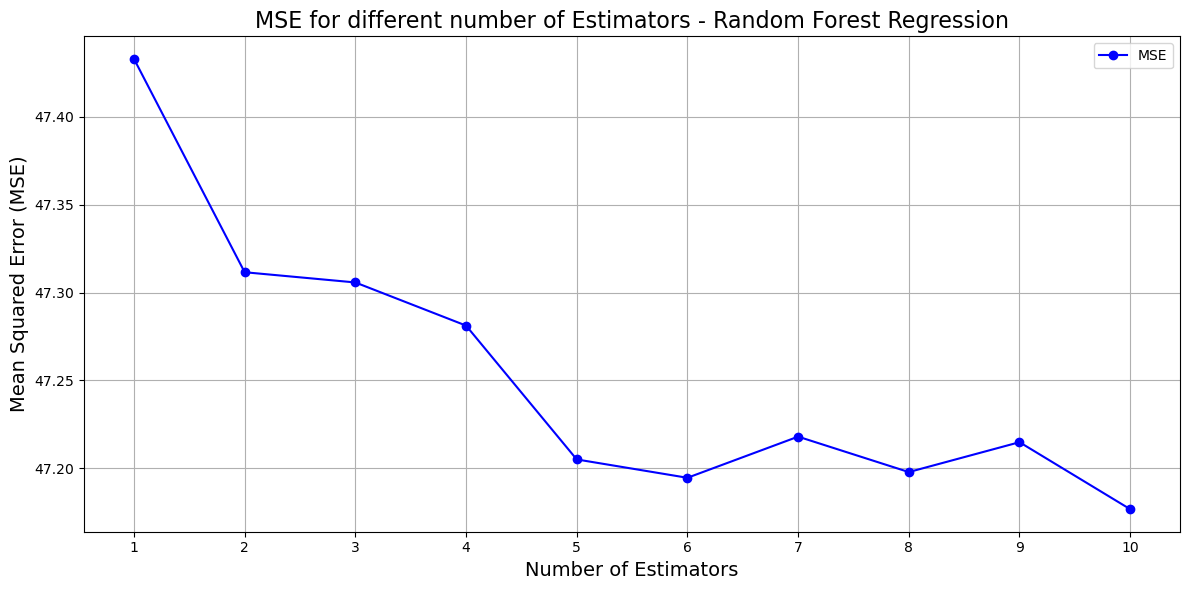

In [34]:

x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(x_b, y_b, test_size=0.5, random_state=42)

n_estimators_range = range(1, 11, 1)
mse_values = []

for n_estimators in n_estimators_range:
    model_b_rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model_b_rf.fit(x_b_train, y_b_train)
    
    y_b_pred = model_b_rf.predict(x_b_test)
    
    mse = mean_squared_error(y_b_test, y_b_pred)
    mse_values.append(mse)

plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, mse_values, marker='o', linestyle='-', color='blue', label='MSE')
plt.title('MSE for different number of Estimators - Random Forest Regression', fontsize=16)
plt.xlabel('Number of Estimators', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.xticks(n_estimators_range)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

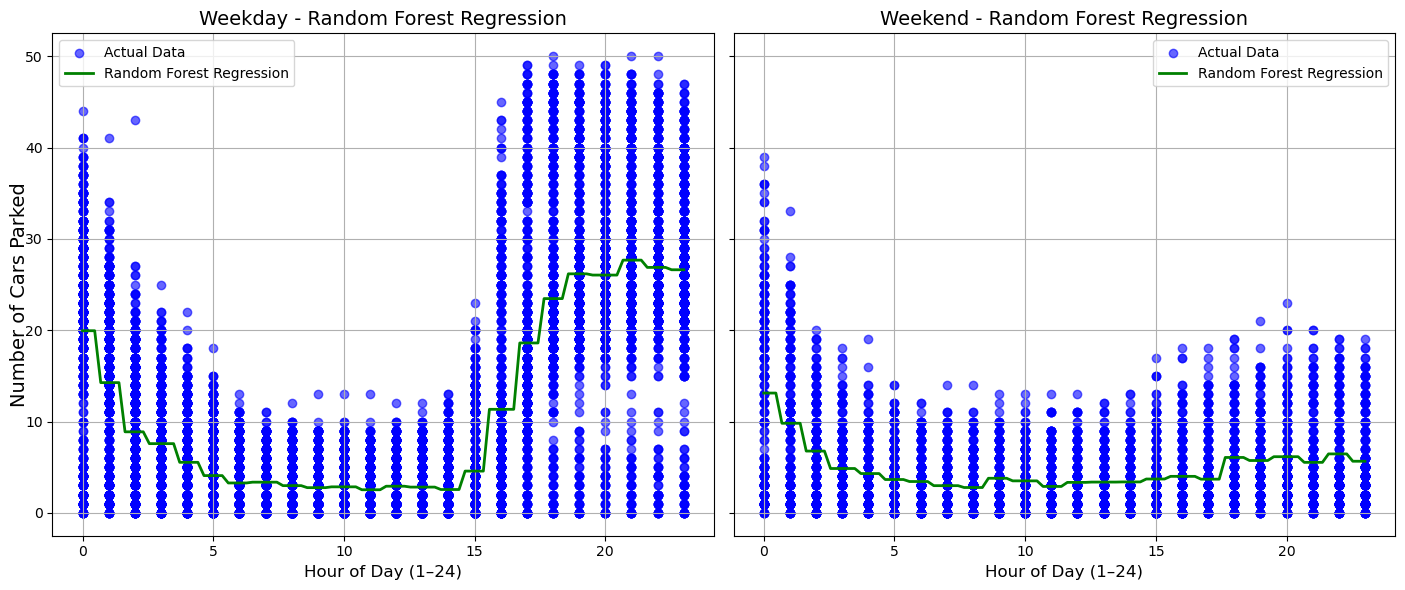

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x_b, y_b, test_size=0.5, random_state=42)

model_b_rf = RandomForestRegressor(n_estimators=1, random_state=42)  
model_b_rf.fit(x_train, y_train)

X_grid = np.linspace(min(x_b[:, 0]), max(x_b[:, 0]), 100).reshape(-1, 1)
X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_b[0, 1]])  
y_grid = model_b_rf.predict(X_grid_combined)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday in zip(axes, ["Weekday", "Weekend"], [1, 0]):
    x_data = x_b[x_b[:, 1] == is_weekday]
    y_data = y_b[x_b[:, 1] == is_weekday]

    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * is_weekday]) 
    y_grid = model_b_rf.predict(X_grid_combined)
    ax.plot(X_grid, y_grid, color='green', label='Random Forest Regression', linewidth=2)

    ax.set_title(f'{title} - Random Forest Regression', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

fig.text(0, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

Neural Network

4/4 [==============================] - 0s 0s/step


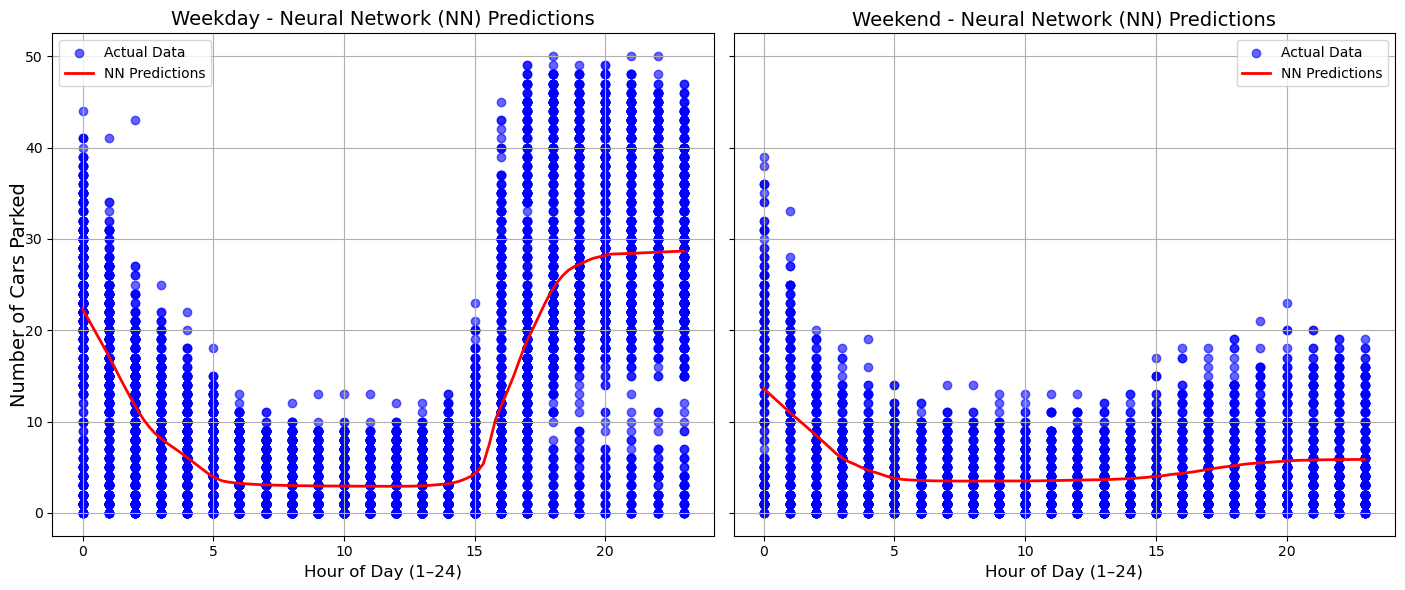

In [36]:
def build_and_train_nn(x_data, y_data):
    scaler = StandardScaler()
    x_data_scaled = scaler.fit_transform(x_data)  

    x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data, test_size=0.5, random_state=42)

    model = Sequential()
    model.add(Dense(512, input_dim=2, activation='relu'))  
    model.add(Dropout(0.3))  
    model.add(Dense(256, activation='relu'))  
    model.add(Dropout(0.3))  
    model.add(Dense(128, activation='relu'))  
    model.add(Dropout(0.3)) 
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(1, activation='linear'))  

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), verbose=0)

    test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)

    X_grid = np.linspace(min(x_data[:, 0]), max(x_data[:, 0]), 100).reshape(-1, 1)
    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_data[0, 1]])  
    X_grid_scaled = scaler.transform(X_grid_combined)  
    y_grid = model.predict(X_grid_scaled)

    return X_grid, y_grid, test_loss, test_mae, model, scaler

X_grid, y_grid, test_loss, test_mae, model_b_neuro, scaler = build_and_train_nn(x_b, y_b)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday in zip(
    axes, 
    ["Weekday", "Weekend"],
    [1, 0]
):
    x_data = x_b[x_b[:, 1] == is_weekday]
    y_data = y_b[x_b[:, 1] == is_weekday]
    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_data[0, 1]])  
    X_grid_scaled = scaler.transform(X_grid_combined)  
    
    y_grid = model_b_neuro.predict(X_grid_scaled)
    
    ax.plot(X_grid[:, 0], y_grid, color='red', label='NN Predictions', linewidth=2)

    ax.set_title(f'{title} - Neural Network (NN) Predictions', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

fig.text(0, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

4/4 [==============================] - 0s 0s/step


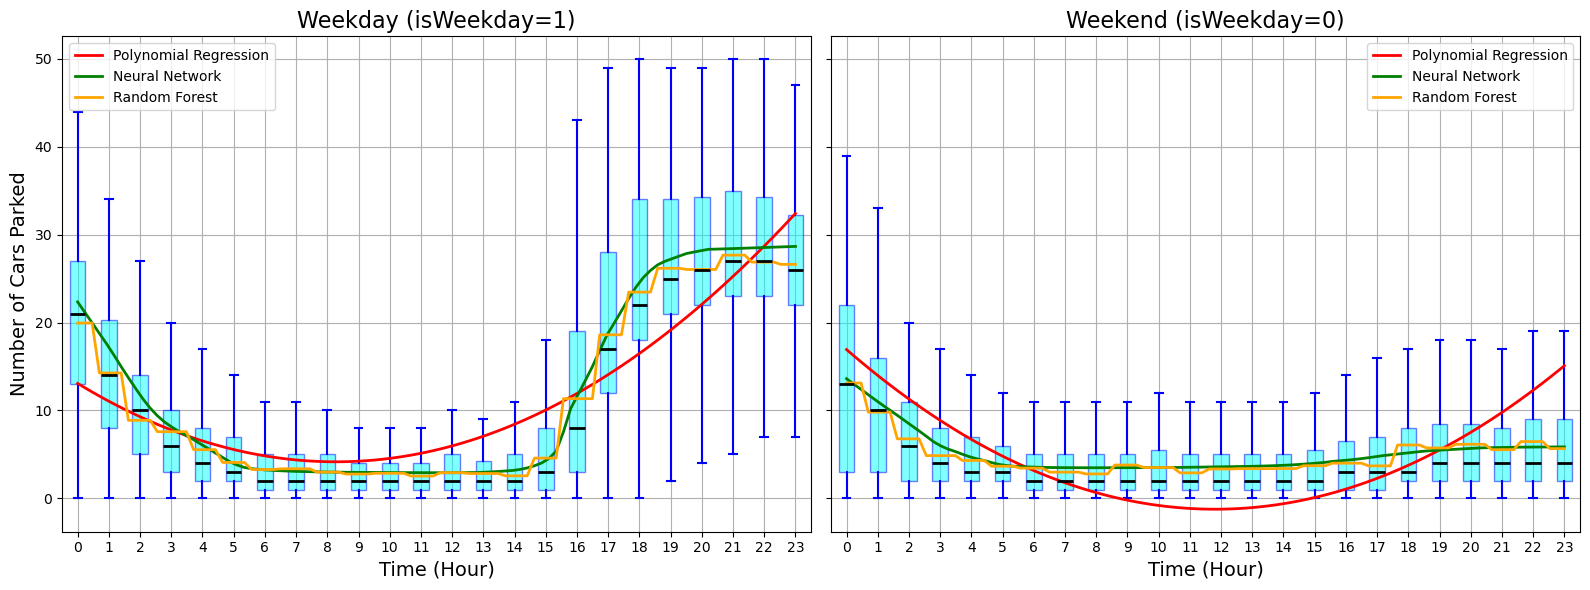

In [37]:
x_weekday = x_b[x_b[:, 1] == 1]
y_weekday = y_b[x_b[:, 1] == 1]
x_weekend = x_b[x_b[:, 1] == 0]
y_weekend = y_b[x_b[:, 1] == 0]

time_grid_weekday = np.linspace(min(x_weekday[:, 0]), max(x_weekday[:, 0]), 100).reshape(-1, 1)
X_grid_weekday = np.hstack([time_grid_weekday, np.ones_like(time_grid_weekday)])  

time_grid_weekend = np.linspace(min(x_weekend[:, 0]), max(x_weekend[:, 0]), 100).reshape(-1, 1)
X_grid_weekend = np.hstack([time_grid_weekend, np.zeros_like(time_grid_weekend)])  

X_grid_weekday_neuro = np.hstack([time_grid_weekday, np.ones_like(time_grid_weekday)]) 
X_grid_weekend_neuro = np.hstack([time_grid_weekend, np.zeros_like(time_grid_weekend)])  

X_grid_weekday_scaled_neuro = scaler.transform(X_grid_weekday)  
X_grid_weekend_scaled_neuro = scaler.transform(X_grid_weekend)

y_grid_neuro_weekday = model_b_neuro.predict(X_grid_weekday_scaled_neuro)
y_grid_neuro_weekend = model_b_neuro.predict(X_grid_weekend_scaled_neuro)


y_grid_poly_weekday = model_b_poly.predict(poly.transform(X_grid_weekday))
y_grid_rf_weekday = model_b_rf.predict(X_grid_weekday)

y_grid_poly_weekend = model_b_poly.predict(poly.transform(X_grid_weekend))
y_grid_rf_weekend = model_b_rf.predict(X_grid_weekend)

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

unique_hours_weekday = np.unique(x_weekday[:, 0])
data_for_boxplot_weekday = [y_weekday[x_weekday[:, 0] == hour] for hour in unique_hours_weekday]

axs[0].boxplot(
    data_for_boxplot_weekday,
    positions=unique_hours_weekday,
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='cyan', color='blue', alpha=0.5),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='blue', linewidth=1.5),
    capprops=dict(color='blue', linewidth=1.5),
    showfliers=False,
)
axs[0].plot(X_grid_weekday[:, 0], y_grid_poly_weekday, color='red', label='Polynomial Regression', linewidth=2)
axs[0].plot(X_grid_weekday[:, 0], y_grid_neuro_weekday, color='green', label='Neural Network', linewidth=2)
axs[0].plot(X_grid_weekday[:, 0], y_grid_rf_weekday, color='orange', label='Random Forest', linewidth=2)
axs[0].set_title('Weekday (isWeekday=1)', fontsize=16)
axs[0].set_xlabel('Time (Hour)', fontsize=14)
axs[0].set_ylabel('Number of Cars Parked', fontsize=14)
axs[0].grid(True)
axs[0].legend()

unique_hours_weekend = np.unique(x_weekend[:, 0])
data_for_boxplot_weekend = [y_weekend[x_weekend[:, 0] == hour] for hour in unique_hours_weekend]

axs[1].boxplot(
    data_for_boxplot_weekend,
    positions=unique_hours_weekend,
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='cyan', color='blue', alpha=0.5),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='blue', linewidth=1.5),
    capprops=dict(color='blue', linewidth=1.5),
    showfliers=False,
)
axs[1].plot(X_grid_weekend[:, 0], y_grid_poly_weekend, color='red', label='Polynomial Regression', linewidth=2)
axs[1].plot(X_grid_weekend[:, 0], y_grid_neuro_weekend, color='green', label='Neural Network', linewidth=2)
axs[1].plot(X_grid_weekend[:, 0], y_grid_rf_weekend, color='orange', label='Random Forest', linewidth=2)
axs[1].set_title('Weekend (isWeekday=0)', fontsize=16)
axs[1].set_xlabel('Time (Hour)', fontsize=14)
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\922401848.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
C:\Users\vigro\AppData\Local\Temp\ipykernel_28964\922401848.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])


4/4 [==============================] - 0s 1ms/step


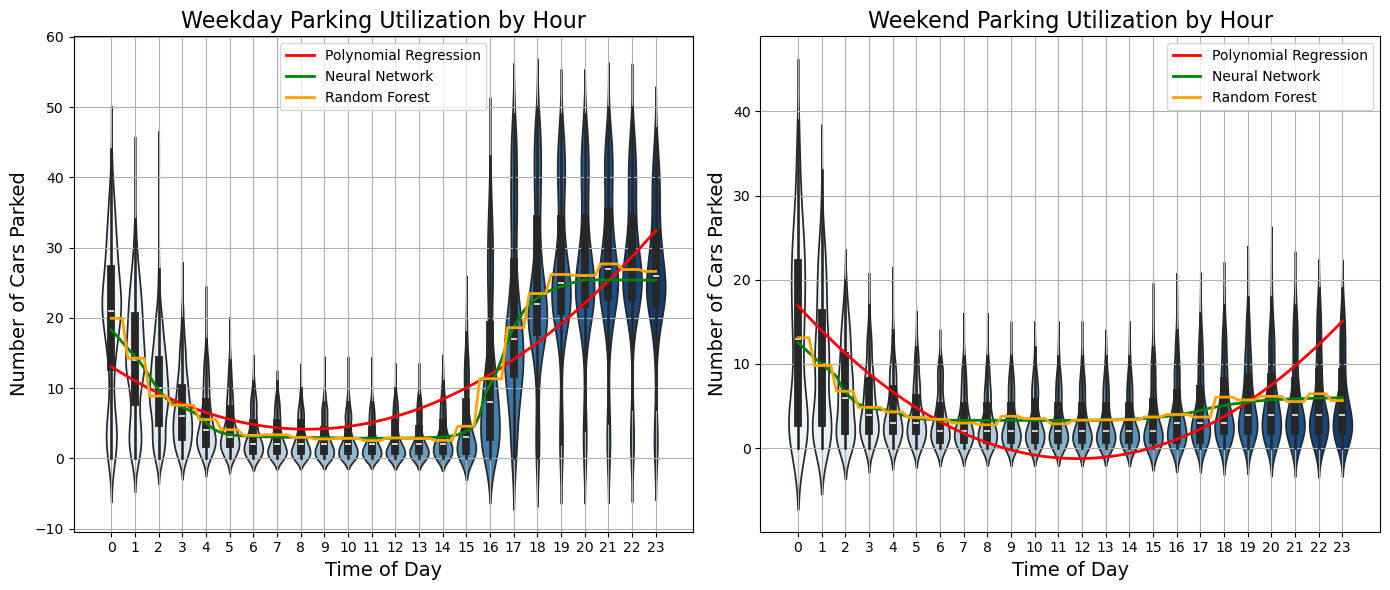

In [27]:
weekday_data = utilization_b[utilization_b['isWeekday'] == 1]
weekend_data = utilization_b[utilization_b['isWeekday'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])

time_range = np.linspace(0, 23, 100).reshape(-1, 1)  

X_grid_weekday = np.hstack([time_range, np.ones_like(time_range)])  
X_grid_weekend = np.hstack([time_range, np.zeros_like(time_range)])  

X_grid_weekday_poly = poly.transform(X_grid_weekday)  
X_grid_weekend_poly = poly.transform(X_grid_weekend)

y_grid_poly_weekday = model_b_poly.predict(X_grid_weekday_poly)
y_grid_poly_weekend = model_b_poly.predict(X_grid_weekend_poly)

y_grid_neuro_weekday = model_b_neuro.predict(scaler.transform(X_grid_weekday))
y_grid_neuro_weekend = model_b_neuro.predict(scaler.transform(X_grid_weekend))

y_grid_rf_weekday = model_b_rf.predict(X_grid_weekday)
y_grid_rf_weekend = model_b_rf.predict(X_grid_weekend)

axes[0].plot(time_range, y_grid_poly_weekday, color='red', label='Polynomial Regression', linewidth=2)
axes[0].plot(time_range, y_grid_neuro_weekday, color='green', label='Neural Network', linewidth=2)
axes[0].plot(time_range, y_grid_rf_weekday, color='orange', label='Random Forest', linewidth=2)

axes[1].plot(time_range, y_grid_poly_weekend, color='red', label='Polynomial Regression', linewidth=2)
axes[1].plot(time_range, y_grid_neuro_weekend, color='green', label='Neural Network', linewidth=2)
axes[1].plot(time_range, y_grid_rf_weekend, color='orange', label='Random Forest', linewidth=2)

axes[0].set_title('Weekday Parking Utilization by Hour', fontsize=16)
axes[1].set_title('Weekend Parking Utilization by Hour', fontsize=16)
for ax in axes:
    ax.set_xlabel('Time of Day', fontsize=14)
    ax.set_ylabel('Number of Cars Parked', fontsize=14)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()